In [1]:
import os
import sys
import pickle
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.special import expit
import pystan
import multiprocessing
import math

In [2]:
import import_ipynb
from model import Model, ModelLocBias

importing Jupyter notebook from model.ipynb
The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


In [3]:
try:
    multiprocessing.set_start_method("fork") # For multiprocessing in stan
except RuntimeError:
    pass
sns.set()  # Nice plot aesthetic

In [4]:
np.random.seed(101)

In [5]:
FIG_FOLDER = 'fig'
SOURCE_FOLDER = os.path.join('data', 'source')
BACKUP_FOLDER = os.path.join('data', 'backup')
print(f"The source folder is: {os.path.abspath(SOURCE_FOLDER)}")
print(f"The figure folder is: {os.path.abspath(FIG_FOLDER)}")
print(f"The backup folder is: {os.path.abspath(BACKUP_FOLDER)}")

# Create folders
for f in SOURCE_FOLDER, FIG_FOLDER, BACKUP_FOLDER:
    os.makedirs(f, exist_ok=True)

The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


In [6]:
DATASET = "A"

# Load the data

In [7]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_fit_overall{DATASET}.csv"))
for c in ("date_begin", "date_end"):
    df_fit[c] = pd.to_datetime(df_fit[c])
df_fit.drop(df_fit.filter(regex="Unname"),axis=1, inplace=True)
df_fit

,distortion,precision,risk_aversion,date_begin,date_end,monkey,condition,n
0,1.327630,0.287248,0.206550,2020-02-22,2020-06-22,Ala,gain,8326
1,1.052253,0.236651,-0.584820,2020-02-22,2020-06-22,Ala,loss,8285
2,0.749594,0.937215,0.101506,2020-02-22,2020-06-22,Alv,gain,9996
3,0.487126,0.674161,-0.358318,2020-02-22,2020-06-22,Alv,loss,9988
4,0.917492,0.500987,-0.110538,2020-02-22,2020-06-22,Bar,gain,10361
5,0.767019,0.203717,-0.637882,2020-02-22,2020-06-22,Bar,loss,10365
6,1.800000,8.078418,0.990000,2020-02-23,2020-06-22,Ola,gain,5235
7,0.516030,5.732120,-0.657987,2020-02-23,2020-06-22,Ola,loss,5237
8,0.200000,4.141394,0.990000,2020-05-20,2020-06-18,Yin,gain,389
9,0.296324,10.000000,0.990000,2020-05-20,2020-06-19,Yin,loss,382


In [8]:
df_elo = pd.read_csv(os.path.join(BACKUP_FOLDER, "df_elo.csv"), index_col=0)
df_elo.index = pd.to_datetime(df_elo.index)
df_elo

,nem,yak,ner,yoh,nen,wot,pac,las,anu,ola,...,olg,jea,pat,bar,ces,lad,ber,dor,eri,fic
date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,1024,1009,1018,984,991,1010,991,982,991,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-26,1032,1009,1018,1003,991,1010,982,964,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-27,1032,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-28,1041,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-29,1063,1009,1018,1011,991,1010,975,941,984,1008,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-21,938,1243,961,840,1018,1234,1379,713,1117,1287,...,933,760,841,1083,837,753,743,766,702,579
2020-10-22,970,1243,962,840,1018,1234,1347,716,1105,1296,...,935,755,841,1070,832,753,743,795,702,566
2020-10-23,971,1243,970,840,1018,1234,1347,735,1105,1296,...,920,751,841,1072,838,753,758,773,668,566


In [9]:
df_demo = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_demo.csv"))
df_demo.weighing_date = pd.to_datetime(df_demo.weighing_date)
df_demo.birthdate = pd.to_datetime(df_demo.birthdate)
df_demo

,monkey,sex,birthdate,weight,weighing_date,age
0,Abr,M,2013-05-14,12.7,2020-01-13,7.670481
1,Ala,M,2013-03-19,12.6,2020-01-13,7.823804
2,Alv,M,2013-02-12,14.6,2020-01-13,7.919631
3,Anu,M,2013-05-21,15.5,2020-01-13,7.651316
4,Bar,M,2014-12-05,10.6,2020-01-13,6.109874
5,Ber,F,2014-11-13,8.4,2020-01-13,6.170108
6,Ces,M,2015-06-05,6.8,2020-01-13,5.611575
7,Dor,F,2016-03-22,4.9,2020-01-13,4.814844
8,Eri,M,2017-03-28,4.1,2020-01-13,3.799081
9,Fic,F,2018-02-21,3.2,2020-01-13,2.895571


# Prepare the data

In [10]:
elo = []

for _, row in df_fit.iterrows():
        
    m = row.monkey
    begin = row.date_begin
    end = row.date_end
        
    df_elo_m = df_elo[m.lower()]
    df_elo_m = df_elo_m[(df_elo_m.index >= begin) & (df_elo_m.index <= end)]
    elo.append(np.mean(df_elo_m))
        

df_fit['elo'] = elo
df_fit

,distortion,precision,risk_aversion,date_begin,date_end,monkey,condition,n,elo
0,1.327630,0.287248,0.206550,2020-02-22,2020-06-22,Ala,gain,8326,1106.786885
1,1.052253,0.236651,-0.584820,2020-02-22,2020-06-22,Ala,loss,8285,1106.786885
2,0.749594,0.937215,0.101506,2020-02-22,2020-06-22,Alv,gain,9996,1096.295082
3,0.487126,0.674161,-0.358318,2020-02-22,2020-06-22,Alv,loss,9988,1096.295082
4,0.917492,0.500987,-0.110538,2020-02-22,2020-06-22,Bar,gain,10361,998.040984
5,0.767019,0.203717,-0.637882,2020-02-22,2020-06-22,Bar,loss,10365,998.040984
6,1.800000,8.078418,0.990000,2020-02-23,2020-06-22,Ola,gain,5235,1426.305785
7,0.516030,5.732120,-0.657987,2020-02-23,2020-06-22,Ola,loss,5237,1426.305785
8,0.200000,4.141394,0.990000,2020-05-20,2020-06-18,Yin,gain,389,894.800000
9,0.296324,10.000000,0.990000,2020-05-20,2020-06-19,Yin,loss,382,895.096774


In [11]:
left = df_fit[df_fit.condition == "loss"]
right = df_fit[df_fit.condition == "gain"]
df = pd.merge(left, right, on=("monkey", "elo", "date_begin", "date_end"), suffixes=('_loss', '_gain'))
df.drop("condition_gain", axis=1, inplace=True)
df.drop("condition_loss", axis=1, inplace=True)
for i, row in df.iterrows():
    try:
        df.loc[i, "age"] = df_demo.loc[df_demo.monkey == row.monkey, 'age'].item()
        df.loc[i, "weight"] = df_demo.loc[df_demo.monkey == row.monkey, 'weight'].item()
        df.loc[i, "sex"] = int(df_demo.loc[df_demo.monkey == row.monkey, 'sex'].item() == "M")
    except IndexError:
        print(row.monkey)
df

,distortion_loss,precision_loss,risk_aversion_loss,date_begin,date_end,monkey,n_loss,elo,distortion_gain,precision_gain,risk_aversion_gain,n_gain,age,weight,sex
0,1.052253,0.236651,-0.584820,2020-02-22,2020-06-22,Ala,8285,1106.786885,1.327630,0.287248,0.206550,8326,7.823804,12.6,1.0
1,0.487126,0.674161,-0.358318,2020-02-22,2020-06-22,Alv,9988,1096.295082,0.749594,0.937215,0.101506,9996,7.919631,14.6,1.0
2,0.767019,0.203717,-0.637882,2020-02-22,2020-06-22,Bar,10365,998.040984,0.917492,0.500987,-0.110538,10361,6.109874,10.6,1.0
3,0.516030,5.732120,-0.657987,2020-02-23,2020-06-22,Ola,5237,1426.305785,1.800000,8.078418,0.990000,5235,8.938132,16.5,1.0
4,0.610697,0.486810,-0.390098,2020-02-22,2020-06-22,Abr,6302,1262.409836,0.673916,0.333890,0.645185,6299,7.670481,12.7,1.0
5,0.743028,0.381228,-0.234483,2020-02-22,2020-06-22,Nem,5001,906.327869,0.787869,0.480714,0.406652,5008,10.025081,9.2,0.0
6,0.897922,0.485241,-0.219357,2020-02-23,2020-06-22,Ces,5632,757.801653,0.666329,0.330431,0.568596,5636,5.611575,6.8,1.0
7,0.360321,0.788312,-0.520387,2020-02-23,2020-06-22,Anu,3480,1174.388430,0.480326,0.412837,0.420829,3494,7.651316,15.5,1.0
8,0.800164,0.383459,-0.667373,2020-02-23,2020-06-22,Yoh,2840,806.785124,0.935791,0.483348,0.712016,2851,11.478910,10.0,0.0
9,0.598453,0.341182,-0.609874,2020-02-26,2020-06-22,Oli,2032,1203.288136,0.656230,0.704264,0.361250,2034,10.126384,15.0,1.0


In [12]:
# Convert dataframe into a dictionary adapted to Stan
data = df.to_dict('list')
data['N'] = len(data["distortion_gain"])
data.pop("date_begin")
data.pop("date_end")
data.pop("monkey")
data

{'distortion_loss': [1.052252697678462,
  0.4871262265240171,
  0.7670193394918364,
  0.5160302846681442,
  0.6106971898927989,
  0.743027584176668,
  0.897921918498676,
  0.3603213992841097,
  0.8001644891582302,
  0.5984525093744678,
  0.5390391453429033,
  0.4435639728781206,
  0.4941215159436743],
 'precision_loss': [0.2366509981785458,
  0.6741606451167367,
  0.2037170684727746,
  5.73211971756915,
  0.4868096953725465,
  0.3812278389184,
  0.4852413012228116,
  0.7883124961810563,
  0.3834591383952768,
  0.3411815221498672,
  0.4472191579592713,
  2.092978568833563,
  0.623430041402662],
 'risk_aversion_loss': [-0.5848200231358437,
  -0.3583181807449984,
  -0.6378815871709644,
  -0.6579871520783548,
  -0.3900981695815877,
  -0.2344833692611206,
  -0.2193569815681458,
  -0.5203874815807027,
  -0.6673725049534803,
  -0.6098737942106696,
  -0.7799556203010937,
  0.3801199341107799,
  -0.7670023086684007],
 'n_loss': [8285,
  9988,
  10365,
  5237,
  6302,
  5001,
  5632,
  3480,
  2

# Model 1

## Define the model

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [13]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    , sigma);
}
"""

## Compile the model

In [14]:
def compile_model(model_name, force_compilation=True):
        # Put it to true if you edit the model

    # Where to save backup
    bkp_file = os.path.join(BACKUP_FOLDER, model_name)
    if not os.path.exists(bkp_file) or force_compilation:

        # Compile the model
        sm = pystan.StanModel(model_code=model)

        # Save the model
        with open(bkp_file, 'wb') as f:
            pickle.dump(sm, f)
    else:
        # Load the model
        sm = pickle.load(open(bkp_file, 'rb'))
    return sm

sm = compile_model('regression_model.pkl', False)

## Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [15]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101,
                  control=dict(adapt_delta=0.9))
fit

Inference for Stan model: anon_model_aef5dc0ffcff107725ff680927909285.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1469.5   25.53 487.82 532.88 1189.1 1457.8 1724.2 2459.9    365   1.01
beta_dist_gain 871.29   33.84 684.73 -471.7 486.74 868.44 1244.3 2207.5    409   1.01
beta_risk_gain -47.46   18.45 443.44 -912.6 -321.6  -48.6 201.46 845.65    577   1.01
beta_prec_gain -87.08   17.15  408.7 -835.2 -325.0 -106.7 138.72 767.45    568   1.01
beta_dist_loss  -1289   52.56 1001.2  -3318  -1821  -1259 -740.0  703.7    363   1.01
beta_risk_loss 341.59   27.84 493.72 -584.6  46.41 335.28 609.51 1315.9    314   1.02
beta_prec_loss   4.51    29.8 624.76  -1269 -322.9  40.39 362.72 1135.9    439   1.01
sigma          263.73    5.13  98.32 147.18 198.42 240.14 301.29 520.25    367   1.01
lp__           -72.26    0.17   3.12 -7

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [16]:
# Cast the fit output to a pandas DataFrame
def fit_to_pd(fit):
    summary_dict = fit.summary()
    df = pd.DataFrame(summary_dict['summary'], 
                      columns=summary_dict['summary_colnames'], 
                      index=summary_dict['summary_rownames'])
    return df

fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1469.567926,25.530347,487.821620,532.883207,1189.124679,1457.836418,1724.265205,2459.977908,365.097315,1.013288
beta_dist_gain,871.291988,33.841914,684.733713,-471.784216,486.736194,868.437351,1244.319865,2207.558405,409.386564,1.010941
beta_risk_gain,-47.463423,18.453271,443.440912,-912.616695,-321.598820,-48.599204,201.461937,845.650847,577.463816,1.006631
beta_prec_gain,-87.075006,17.151931,408.701675,-835.214896,-325.018340,-106.772791,138.718477,767.454279,567.788771,1.005705
beta_dist_loss,-1289.687555,52.556424,1001.218478,-3318.622942,-1821.406759,-1259.623826,-740.014771,703.699436,362.915979,1.013809
beta_risk_loss,341.585247,27.842209,493.718244,-584.693925,46.414375,335.283456,609.505516,1315.952119,314.449546,1.016277
beta_prec_loss,4.510068,29.802686,624.759379,-1269.098569,-322.946538,40.392765,362.721869,1135.916607,439.455342,1.009415
sigma,263.725833,5.132849,98.316989,147.184998,198.416662,240.143344,301.294002,520.251147,366.893573,1.010772
lp__,-72.263723,0.171368,3.123862,-79.422631,-73.966626,-71.783632,-69.955530,-67.808816,332.294088,1.007889


## Plot the results

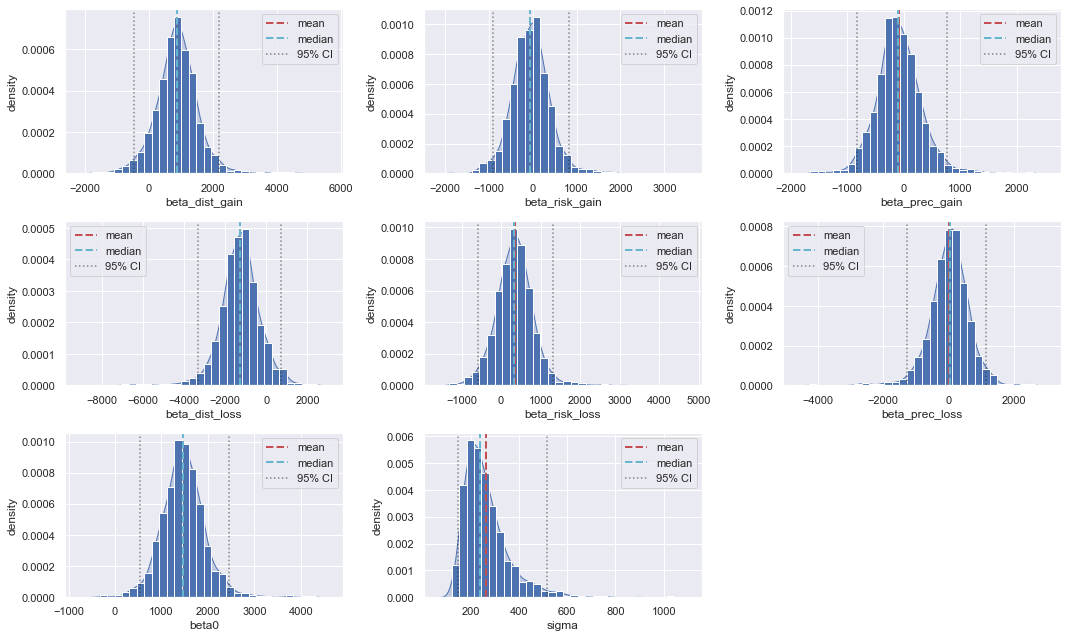

In [17]:
def plot(fit, ncols=3):
    
    var_names = list(fit.summary()["summary_rownames"])
    var_names.remove("lp__")
    var_names.remove("beta0")
    var_names.remove("sigma")
    params = var_names + ['beta0', 'sigma']
    
    nrows = math.ceil(len(params)/ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
    axes = axes.flatten()

    for i, param_name in enumerate(params):

        # Extract trace
        param = fit[param_name]

        # Summary statistics
        mean = np.mean(param)
        median = np.median(param)
        cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

        # Plotting
        ax = axes[i]
        ax.hist(param, 30, density=True)
        sns.kdeplot(param, shade=True, ax=ax)
        ax.set_xlabel(param_name)
        ax.set_ylabel('density')
        ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
        ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
        ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
        ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
        ax.legend()
    
    for i in range(len(params), ncols*nrows):
        fig.delaxes(axes[i])

    plt.tight_layout()    
    plt.show()

plot(fit)

## Interpreation

In gain:
* proba: the more inverse s-shaped, the higher in the hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the less precise, the higher in hirearchy

In loss: 
* proba: no relation? tendance: the less inverse s-shpaed, the higher in hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the more precise, the higher in hierarchy

TO DO:

* Add age / weight / gender
* Model side bias
* Filtering data (side bias, low performance to control task, number of trials)
* Regression on performance
* Fit Vizualizing 

# Model 2 (Full model: DM parameters, sex, age, weight)

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{sex} sex + \beta_{age} age + \beta_{weight} weight + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [18]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] weight;
    vector[N] age;
    vector[N] sex;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real beta_age;
    real beta_sex;
    real beta_wgt;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
        + beta_dist_gain * distortion_gain
        + beta_risk_gain * risk_aversion_gain
        + beta_prec_gain * precision_gain
        + beta_dist_loss * distortion_loss
        + beta_risk_loss * risk_aversion_loss
        + beta_prec_loss * precision_loss
        + beta_age * age
        + beta_wgt * weight
        + beta_sex * sex
        , sigma);
}
"""

In [19]:
sm = compile_model('regression_model2.pkl', False)

In [20]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101, 
                  control=dict(adapt_delta=0.9,  max_treedepth=10))
fit

Inference for Stan model: anon_model_2dcdca10b8a351c703d9817ed6b00474.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          229.37  559.11 6470.0  -4450 129.83  706.5 1352.8 5168.0    134   1.01
beta_dist_gain -87.75  846.43 7084.7  -8059 -140.3 620.33 1483.8 5702.4     70   1.03
beta_risk_gain 186.59  257.52 3428.9  -1865 -91.35  191.9 487.24 2599.9    177    1.0
beta_prec_gain  64.78   98.49 1683.6  -1721 -217.2  32.45 258.38 2009.4    292    1.0
beta_dist_loss  38.99  1249.9  1.0e4  -8980  -2301 -993.5 199.53  1.2e4     67   1.03
beta_risk_loss -86.11  188.82 2330.3  -2469 -252.5  64.22 385.78 2174.9    152   1.01
beta_prec_loss -79.59  172.29 2727.1  -2991 -522.2 -159.4  231.8 2590.1    251    1.0
beta_age        13.26   29.19 329.63 -332.9  -3.56  39.56  80.38 278.95    128   1.03
beta_sex        256.9  175.73 2238.1  -

In [21]:
fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,229.367859,559.112672,6470.057432,-4450.754862,129.825967,706.495245,1352.855597,5168.066714,133.911416,1.013556
beta_dist_gain,-87.748436,846.429736,7084.765321,-8059.847422,-140.368413,620.325075,1483.865427,5702.436052,70.059836,1.032206
beta_risk_gain,186.590654,257.520728,3428.947158,-1865.528245,-91.347664,191.895034,487.235478,2599.952039,177.295291,1.002866
beta_prec_gain,64.779395,98.488542,1683.631987,-1721.162738,-217.233385,32.451692,258.378769,2009.431921,292.228739,1.000574
beta_dist_loss,38.987533,1249.919397,10224.579445,-8980.103183,-2301.017012,-993.551270,199.531896,12465.195683,66.915525,1.032484
beta_risk_loss,-86.106171,188.819184,2330.301247,-2469.852825,-252.591395,64.224294,385.777946,2174.973391,152.311222,1.011304
beta_prec_loss,-79.589917,172.285175,2727.103721,-2991.246905,-522.201734,-159.423984,231.800312,2590.128552,250.557550,1.000714
beta_age,13.260838,29.188577,329.632328,-332.976974,-3.563594,39.555483,80.384166,278.947175,127.536278,1.029981
beta_sex,256.897219,175.725886,2238.125011,-2390.724673,35.972354,384.349772,708.843290,2399.108250,162.217311,1.024621
beta_wgt,37.812082,51.642284,468.048185,-415.871445,-68.927275,-9.028203,61.022522,626.480482,82.142940,1.037210


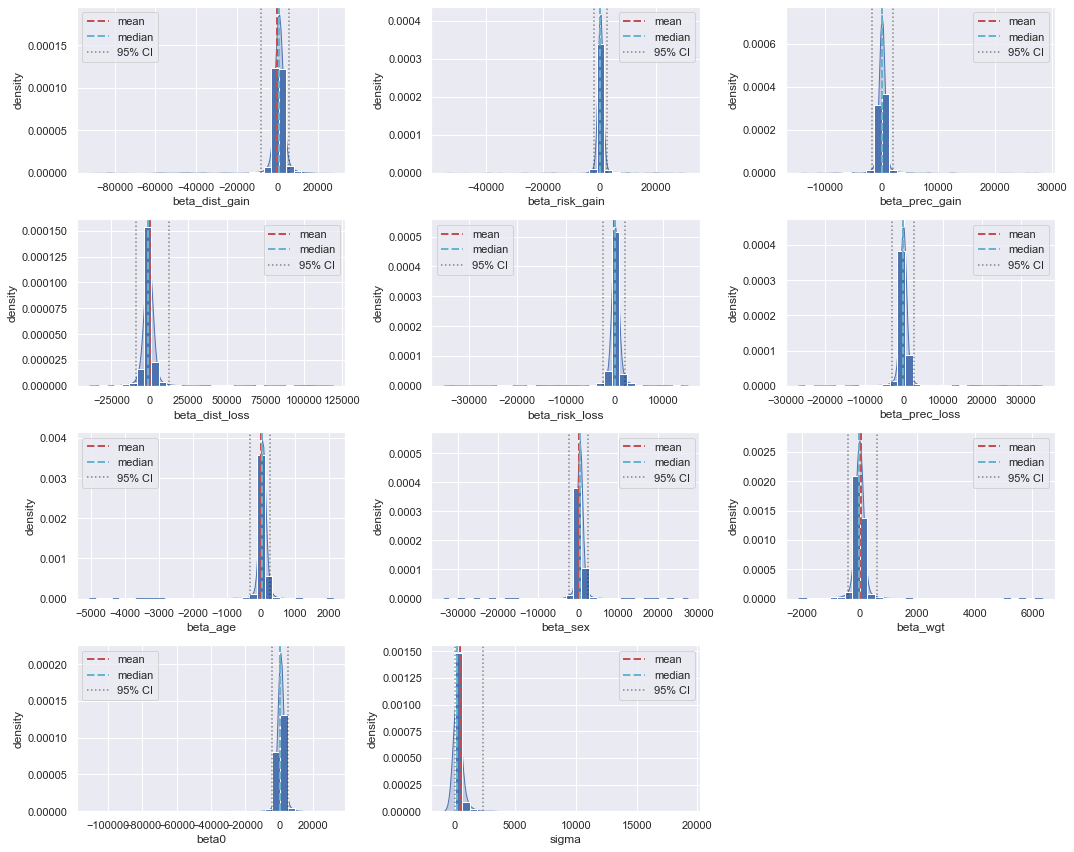

In [22]:
plot(fit)

# Model 3 (with sex, age, weight, only )

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{sex} sex + \beta_{age} age + \beta_{weight} weight + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [23]:
model = """
data {
    int<lower=0> N;
    vector[N] weight;
    vector[N] age;
    vector[N] sex;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_age;
    real beta_sex;
    real beta_wgt;
    real<lower=0> sigma;
}
model {
    elo ~ normal(
        beta0 
        + beta_age * age
        + beta_wgt * weight
        + beta_sex * sex
        , sigma);
}
"""

In [24]:
sm = compile_model('regression_model3.pkl', False)

In [25]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101,
                  control=dict(adapt_delta=0.9))
fit

Inference for Stan model: anon_model_329d4f911b3ae87962ec779fb806ca55.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0    344.29    4.77 143.66  65.34 257.87 344.98 429.01  642.4    908    1.0
beta_age   2.36    0.48  12.21 -22.35  -4.94    2.7   9.69  25.45    651    1.0
beta_sex  88.62     4.8 124.18 -172.2  12.74  91.44 166.88 322.22    670    1.0
beta_wgt  52.96    0.65  16.32  19.51  42.75  53.47  62.96  85.19    625   1.01
sigma    117.26    1.35  34.65  69.68  94.11 109.88 134.45 209.84    663    1.0
lp__     -62.66     0.1   2.08 -67.77 -63.72 -62.25 -61.14 -59.93    457    1.0

Samples were drawn using NUTS at Fri Jan 29 13:52:41 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [26]:
fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,344.286403,4.768290,143.664394,65.344636,257.865112,344.980208,429.009664,642.395001,907.764052,1.002879
beta_age,2.360490,0.478375,12.210173,-22.348273,-4.939177,2.696375,9.692814,25.450146,651.487158,1.004071
beta_sex,88.621064,4.796715,124.180101,-172.290967,12.741390,91.437777,166.883866,322.222070,670.218271,1.004523
beta_wgt,52.958903,0.652574,16.320631,19.511515,42.747758,53.469407,62.963108,85.192683,625.481579,1.008480
sigma,117.262784,1.346069,34.647283,69.675335,94.107770,109.882070,134.454044,209.836507,662.526770,1.001663
lp__,-62.662371,0.097487,2.083942,-67.773126,-63.717432,-62.248699,-61.142440,-59.932259,456.963255,1.003454


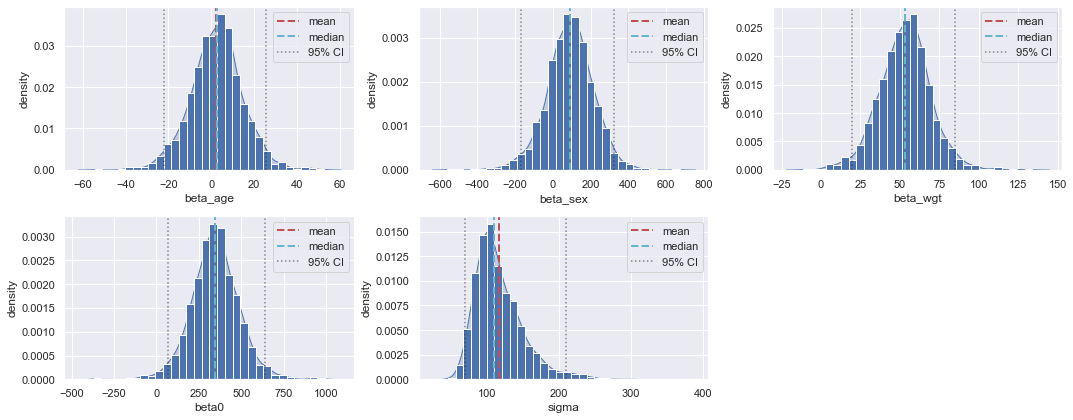

In [27]:
plot(fit)

# Including the side-bias 

In [28]:
MODEL = ModelLocBias 

## Load the fit

In [29]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_fit_overall{DATASET}_{MODEL.__name__}.csv"))
for c in ("date_begin", "date_end"):
    df_fit[c] = pd.to_datetime(df_fit[c])
df_fit.drop(df_fit.filter(regex="Unname"),axis=1, inplace=True)
df_fit

,distortion,precision,risk_aversion,loc_bias,date_begin,date_end,monkey,condition,n
0,1.327775,0.285684,0.206004,0.051842,2020-02-22,2020-06-22,Ala,gain,8326
1,1.051529,0.231330,-0.582592,-0.071694,2020-02-22,2020-06-22,Ala,loss,8285
2,0.768159,0.447276,0.075584,-0.936214,2020-02-22,2020-06-22,Alv,gain,9996
3,0.462213,0.229596,-0.398661,-0.675575,2020-02-22,2020-06-22,Alv,loss,9988
4,0.915509,0.492803,-0.109141,-0.117283,2020-02-22,2020-06-22,Bar,gain,10361
5,0.769959,0.189979,-0.640682,-0.121369,2020-02-22,2020-06-22,Bar,loss,10365
6,0.250000,1.612589,0.083753,-10.000000,2020-02-23,2020-06-22,Ola,gain,5235
7,0.250000,0.330200,-0.903815,-1.570219,2020-02-23,2020-06-22,Ola,loss,5237
8,0.610421,0.704556,0.750000,2.518428,2020-05-20,2020-06-18,Yin,gain,389
9,0.888765,2.477640,0.571941,10.000000,2020-05-20,2020-06-19,Yin,loss,382


## Prepare the data

In [30]:
elo = []

for _, row in df_fit.iterrows():
        
    m = row.monkey
    begin = row.date_begin
    end = row.date_end
        
    df_elo_m = df_elo[m.lower()]
    df_elo_m = df_elo_m[(df_elo_m.index >= begin) & (df_elo_m.index <= end)]
    elo.append(np.mean(df_elo_m))
        

df_fit['elo'] = elo

In [31]:
left = df_fit[df_fit.condition == "loss"]
right = df_fit[df_fit.condition == "gain"]
df = pd.merge(left, right, on=("monkey", "elo", "date_begin", "date_end"), suffixes=('_loss', '_gain'))
df.drop("condition_gain", axis=1, inplace=True)
df.drop("condition_loss", axis=1, inplace=True)
for i, row in df.iterrows():
    try:
        df.loc[i, "age"] = df_demo.loc[df_demo.monkey == row.monkey, 'age'].item()
        df.loc[i, "weight"] = df_demo.loc[df_demo.monkey == row.monkey, 'weight'].item()
        df.loc[i, "sex"] = int(df_demo.loc[df_demo.monkey == row.monkey, 'sex'].item() == "M")
    except IndexError:
        print(row.monkey)

df.loc_bias_loss = np.abs(df.loc_bias_loss.values)
df.loc_bias_gain = np.abs(df.loc_bias_gain.values)
df

,distortion_loss,precision_loss,risk_aversion_loss,loc_bias_loss,date_begin,date_end,monkey,n_loss,elo,distortion_gain,precision_gain,risk_aversion_gain,loc_bias_gain,n_gain,age,weight,sex
0,1.051529,0.231330,-0.582592,0.071694,2020-02-22,2020-06-22,Ala,8285,1106.786885,1.327775,0.285684,0.206004,0.051842,8326,7.823804,12.6,1.0
1,0.462213,0.229596,-0.398661,0.675575,2020-02-22,2020-06-22,Alv,9988,1096.295082,0.768159,0.447276,0.075584,0.936214,9996,7.919631,14.6,1.0
2,0.769959,0.189979,-0.640682,0.121369,2020-02-22,2020-06-22,Bar,10365,998.040984,0.915509,0.492803,-0.109141,0.117283,10361,6.109874,10.6,1.0
3,0.250000,0.330200,-0.903815,1.570219,2020-02-23,2020-06-22,Ola,5237,1426.305785,0.250000,1.612589,0.083753,10.000000,5235,8.938132,16.5,1.0
4,0.610913,0.486384,-0.389759,0.044906,2020-02-22,2020-06-22,Abr,6302,1262.409836,0.674636,0.315598,0.650498,0.154676,6299,7.670481,12.7,1.0
5,3.146037,4.364985,0.009900,2.918730,2020-02-22,2020-06-22,Nem,5001,906.327869,4.000000,4.075483,-0.012649,2.841584,5008,10.025081,9.2,0.0
6,0.896678,0.456582,-0.223548,0.207527,2020-02-23,2020-06-22,Ces,5632,757.801653,0.682652,0.293991,0.571963,0.234865,5636,5.611575,6.8,1.0
7,0.556572,3.342894,-1.932573,5.533494,2020-02-23,2020-06-22,Anu,3480,1174.388430,0.483596,0.274798,0.439750,0.415323,3494,7.651316,15.5,1.0
8,0.801598,0.371508,-0.657946,0.156579,2020-02-23,2020-06-22,Yoh,2840,806.785124,0.975279,0.337290,0.730696,0.478002,2851,11.478910,10.0,0.0
9,0.595455,0.338832,-0.608765,0.054098,2020-02-26,2020-06-22,Oli,2032,1203.288136,4.000000,3.507992,-0.016318,5.928025,2034,10.126384,15.0,1.0


In [32]:
# Convert dataframe into a dictionary adapted to Stan
data = df.to_dict('list')
data['N'] = len(data["distortion_gain"])
data.pop("date_begin")
data.pop("date_end")
data.pop("monkey")
data

{'distortion_loss': [1.051529467157979,
  0.4622131281571543,
  0.7699585963504393,
  0.25,
  0.6109125797351685,
  3.146036570449859,
  0.8966781115273805,
  0.556572275725286,
  0.8015981312053857,
  0.5954549524079402,
  3.983403523205157,
  0.4668170725989621,
  0.485292203325193],
 'precision_loss': [0.2313303691209499,
  0.2295961493873237,
  0.189979067905256,
  0.330199715939069,
  0.4863837404951076,
  4.364985284228846,
  0.4565824946141308,
  3.342894494315603,
  0.3715076743999835,
  0.338832463798926,
  4.907822929160847,
  2.279537604000585,
  0.5929277700603497],
 'risk_aversion_loss': [-0.5825924920704907,
  -0.3986605696920334,
  -0.6406817224728456,
  -0.903815405175226,
  -0.3897588210600837,
  0.0099002417141462,
  -0.2235479599175706,
  -1.9325730467876163,
  -0.6579458902929478,
  -0.6087650594801851,
  -0.9530342966963048,
  0.75,
  -0.7938769796716547],
 'loc_bias_loss': [0.0716940938334852,
  0.675574714920218,
  0.1213685594431351,
  1.570219396774808,
  0.044

# Model 4 (DM parameters including side bias)

We assume that:

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- + e
\end{equation}
with $e$ a gaussian noise:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (0, \sigma) \\
\end{split}
\end{equation}

In [48]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] loc_bias_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] loc_bias_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_loca_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real beta_loca_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    + beta_loca_gain * loc_bias_gain
    + beta_loca_loss * loc_bias_loss
    , sigma);
}
"""

In [49]:
sm = compile_model('regression_model_LOC.pkl', False)

In [50]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101,
                  control={"adapt_delta": 0.9, "max_treedepth":15})
fit

Inference for Stan model: anon_model_affb982ae7ef65a5b2600967de061d61.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1771.6   50.02 631.31 511.78 1448.3 1793.0 2103.2 2962.1    159   1.03
beta_dist_gain 962.17   33.19 491.77  -39.6 701.98  958.6 1232.8 1957.1    220   1.01
beta_risk_gain -857.1   36.55 530.81  -1836  -1140 -867.8 -575.5 208.95    211   1.02
beta_prec_gain  -1665   60.07 818.43  -3298  -2124  -1659  -1210 -33.43    186   1.02
beta_loca_gain 347.19   11.08 154.56  40.86 262.57 347.26 434.66 661.83    195   1.02
beta_dist_loss  -1082   55.91 696.13  -2445  -1447  -1087 -689.9 297.88    155   1.02
beta_risk_loss 712.61    39.5 491.43 -251.2 432.83 719.81 989.41 1694.8    155   1.02
beta_prec_loss 1392.5   65.73 820.88 -262.4 925.66 1409.5 1827.1 3011.4    156   1.02
beta_loca_loss -547.4   26.76 334.77  -

In [51]:
fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1771.641016,50.015200,631.309477,511.783836,1448.353679,1793.083362,2103.283036,2962.109213,159.323776,1.028861
beta_dist_gain,962.167021,33.192735,491.772626,-39.600222,701.981013,958.595972,1232.805344,1957.165951,219.504092,1.014868
beta_risk_gain,-857.149861,36.552969,530.808114,-1836.085527,-1140.855975,-867.840310,-575.577920,208.946788,210.877283,1.024606
beta_prec_gain,-1665.122065,60.070708,818.434883,-3298.581868,-2124.744064,-1659.760478,-1210.244852,-33.431581,185.627694,1.019307
beta_loca_gain,347.188319,11.075963,154.563330,40.859583,262.568306,347.264837,434.660878,661.827817,194.737669,1.017438
beta_dist_loss,-1082.141206,55.911083,696.127977,-2445.599042,-1447.065103,-1087.374955,-689.932170,297.875494,155.018086,1.024450
beta_risk_loss,712.606693,39.498068,491.431621,-251.231811,432.831103,719.810045,989.405841,1694.836937,154.801261,1.024321
beta_prec_loss,1392.578771,65.726102,820.876441,-262.472094,925.656221,1409.554354,1827.193454,3011.432840,155.983921,1.024082
beta_loca_loss,-547.494341,26.761294,334.766328,-1173.119624,-728.402204,-554.334675,-356.362368,116.009724,156.483776,1.023728
sigma,235.166839,13.364175,136.823263,97.544455,148.995172,195.411040,276.830541,605.201059,104.817932,1.027654


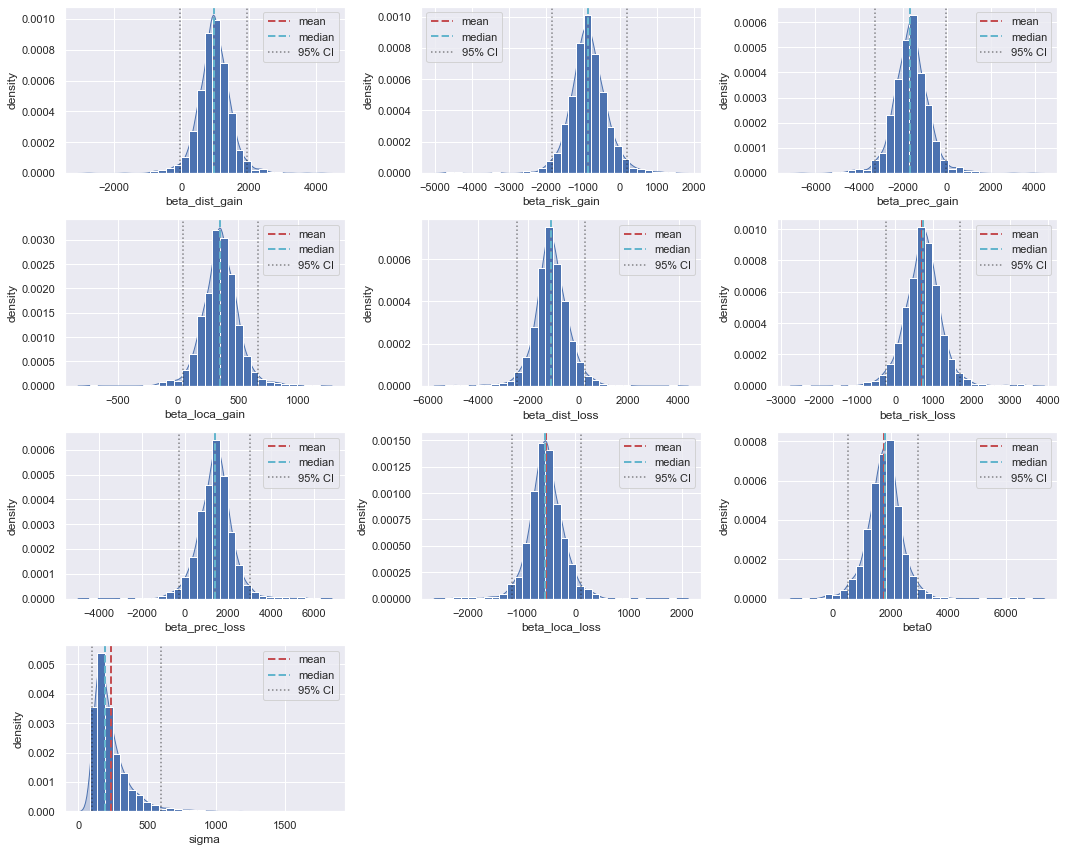

In [52]:
plot(fit)

# Model 5 (DM side-bias only gain related)

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + \beta_{dist^+} dist^+ + \beta_{prec^+} prec^+ \beta_{loc^+} loc^+ + e
\end{equation}

In [43]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] loc_bias_gain;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_loca_gain;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_loca_gain * loc_bias_gain
    , sigma);
}
"""

In [44]:
sm = compile_model('regression_model_LOC_gain.pkl', False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4c2a5cf722b6b90fb42835096b1af5f NOW.


In [45]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=500, thin=1, seed=101,
                  control={"adapt_delta": 0.99, "max_treedepth":15})
fit

Inference for Stan model: anon_model_c4c2a5cf722b6b90fb42835096b1af5f.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1091.7    5.52 233.48 635.03 961.04 1096.2 1228.1 1534.0   1792    1.0
beta_dist_gain  69.62    6.42 243.89 -397.4 -78.69  67.99 209.31 548.16   1444    1.0
beta_risk_gain -236.4    7.72 355.01 -901.3 -447.5 -240.3 -36.89 461.97   2116    1.0
beta_prec_gain -153.0    7.35 278.48 -707.3 -318.1 -154.0   18.9  365.9   1436    1.0
beta_loca_gain  57.99    1.38  54.01 -49.58  26.39  57.38  88.98  163.8   1536    1.0
sigma          268.16    2.59  90.23 156.94 208.41 249.35  307.5  489.0   1217    1.0
lp__           -72.53    0.08   2.52 -78.59 -73.82 -72.05 -70.68 -69.13   1054    1.0

Samples were drawn using NUTS at Fri Jan 29 13:57:23 2021.
For each parameter, n_eff is a crude measure of effective sample

In [46]:
fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1091.779111,5.515826,233.482959,635.030673,961.035920,1096.200444,1228.165947,1534.000390,1791.799180,1.000935
beta_dist_gain,69.623893,6.417879,243.889189,-397.490859,-78.694999,67.993483,209.313079,548.160309,1444.115812,1.001245
beta_risk_gain,-236.492035,7.717947,355.014708,-901.339037,-447.559084,-240.374629,-36.885068,461.973194,2115.870777,1.002802
beta_prec_gain,-152.996632,7.350154,278.484443,-707.357586,-318.120603,-154.043960,18.898969,365.904429,1435.519260,1.001979
beta_loca_gain,57.992536,1.378191,54.012019,-49.582272,26.390882,57.379180,88.984115,163.800676,1535.897335,1.000659
sigma,268.162434,2.586135,90.229221,156.940016,208.414351,249.353508,307.498146,488.998190,1217.284785,1.000508
lp__,-72.531200,0.077599,2.519685,-78.590744,-73.818639,-72.048414,-70.684109,-69.128128,1054.351311,1.000838


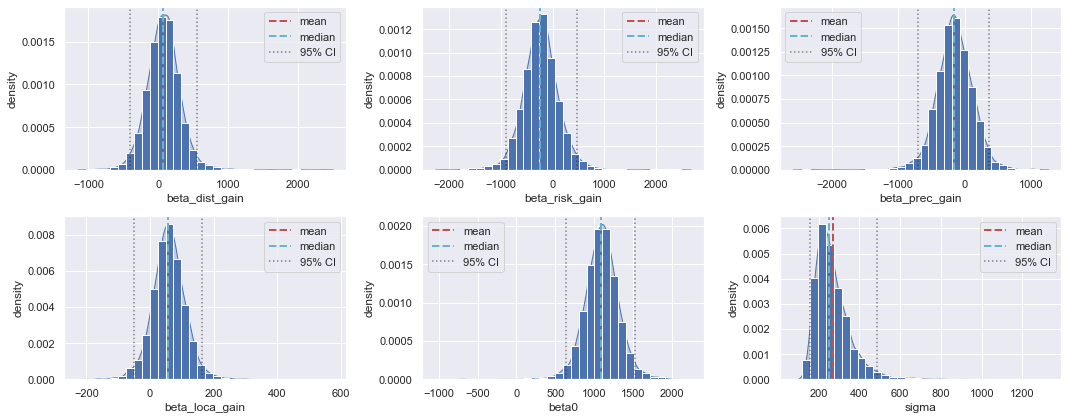

In [47]:
plot(fit)

# Model 6 (DM side-bias only loss related)

\begin{equation}
elo \sim \beta_0 + \beta_{risk^-} risk^- + \beta_{dist^-} dist^- + \beta_{prec^-} prec^- \beta_{loc^-} loc^- + e
\end{equation}

In [56]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] loc_bias_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real beta_loca_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    + beta_loca_loss * loc_bias_loss
    , sigma);
}
"""

In [57]:
sm = compile_model('regression_model_LOC_loss.pkl', False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_606cc2d0c85f3aabea594e05ca732f0f NOW.


In [58]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=500, thin=1, seed=101,
                  control={"adapt_delta": 0.99, "max_treedepth":15})
fit

Inference for Stan model: anon_model_606cc2d0c85f3aabea594e05ca732f0f.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          804.89    6.82 245.17 299.72 656.71 806.49  954.1 1283.9   1292    1.0
beta_dist_loss 212.93    8.12 281.21 -345.1  41.05 208.42 388.69 778.33   1200    1.0
beta_risk_loss -211.0    5.07 195.27 -611.9 -332.4 -211.8 -89.47 187.07   1486    1.0
beta_prec_loss -199.5     7.6 261.01 -728.9 -363.6 -195.7 -39.15 319.08   1179    1.0
beta_loca_loss 101.17    3.22 111.83 -123.9  33.17  99.68 171.16 329.32   1208    1.0
sigma          293.53    2.52  91.98 172.89 229.64  273.6 335.82 534.31   1331    1.0
lp__           -73.73    0.07   2.39 -79.46 -75.09 -73.27 -71.93  -70.4   1041    1.0

Samples were drawn using NUTS at Fri Jan 29 14:10:23 2021.
For each parameter, n_eff is a crude measure of effective sample

In [59]:
fit_to_pd(fit)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,804.887307,6.821652,245.174619,299.718514,656.708900,806.488539,954.101755,1283.942081,1291.730524,1.000917
beta_dist_loss,212.933188,8.119376,281.212668,-345.108065,41.052668,208.416686,388.687164,778.325386,1199.566869,1.001468
beta_risk_loss,-211.050233,5.065744,195.266337,-611.988708,-332.438598,-211.804923,-89.467159,187.067708,1485.827094,1.000872
beta_prec_loss,-199.554920,7.602299,261.014213,-728.937577,-363.685890,-195.766350,-39.145703,319.084742,1178.795359,1.001511
beta_loca_loss,101.174852,3.217815,111.828866,-123.984468,33.166605,99.684515,171.161721,329.322258,1207.774093,1.001126
sigma,293.533786,2.521246,91.977427,172.886190,229.641586,273.603510,335.822275,534.307470,1330.859383,1.003184
lp__,-73.729754,0.074090,2.391006,-79.457539,-75.091161,-73.267174,-71.925994,-70.400114,1041.458356,1.003368


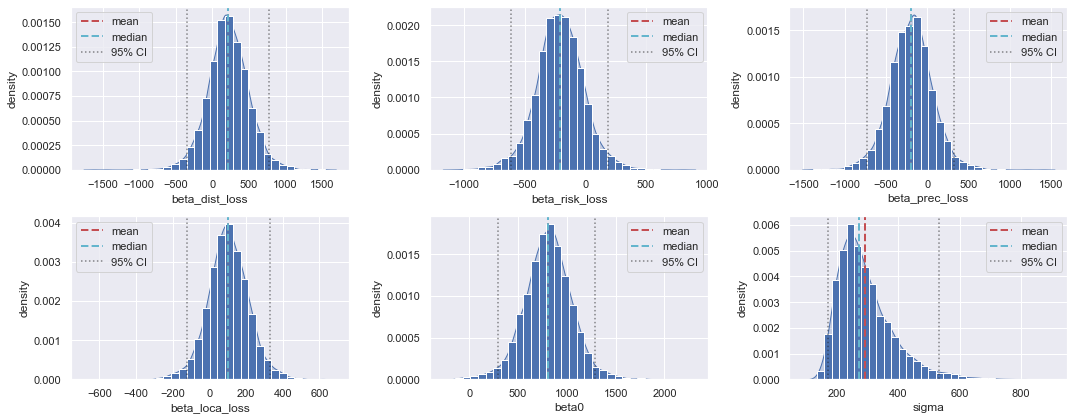

In [60]:
plot(fit)

# TO DO

## Dataset A
- Remove monkeys with side bias (freq. choice one side) / Number of trials 
- Check parameter bounds
- Test regression model with gain-related parameters

## Dataset B
- Split dataset B
- Remove monkeys with side bias (freq. choice one side) / Number of trials 
- Model Dataset A / B_left / B_right

## Control performance
- Model control trials
- Regression models with performance-related parameters (logistic)